In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import sys
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out.basics import create_dir, files_in_subdirs

from geo_tool import Point_Cloud

from tf_lab.in_out.basics import Data_Splitter, read_saved_epochs
from tf_lab.point_clouds.ae_templates import mlp_architecture_ala_iclr_18, default_train_params

from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder

from tf_lab.point_clouds.in_out import load_point_clouds_from_filenames, PointCloudDataSet
from tf_lab.data_sets.model_net import pc_loader, classes_to_integers
from tf_lab.point_clouds.encoders_decoders import decoder_with_fc_only, encoder_with_convs_and_symmetry_new

from tf_lab.nips.helper import average_per_class

from tf_lab.point_clouds.point_net_classifier import PointNetClassifier
from tf_lab.point_clouds.convenience import classify_pclouds

In [3]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline
%matplotlib nbagg

In [4]:
model_net = '40'
verbose = True
n_threads = 20
put_in_usphere = True
n_pc_points = 4096

In [5]:
model_net_dir = '/orions4-zfs/projects/optas/DATA/Point_Clouds/Model_Net_' + model_net +  '/from_manifold/'
model_net_dir = osp.join(model_net_dir, str(n_pc_points))

search_pattern = '(.*)train(.*)\.ply$'
train_pc_files = [f for f in files_in_subdirs(model_net_dir, search_pattern)]

search_pattern = '(.*)test(.*)\.ply$'
test_pc_files = [f for f in files_in_subdirs(model_net_dir, search_pattern)]

In [19]:
train_pc, train_model_names, train_classes = load_point_clouds_from_filenames(train_pc_files, n_threads, pc_loader, verbose)
train_labels = np.array(classes_to_integers(int(model_net), train_classes)[1])

test_pc, test_model_names, test_classes = load_point_clouds_from_filenames(test_pc_files, n_threads, pc_loader, verbose)
test_labels = np.array(classes_to_integers(int(model_net), test_classes)[1])

9843 pclouds were loaded. They belong in 40 shape-classes.
2468 pclouds were loaded. They belong in 40 shape-classes.


In [20]:
for i in range(len(train_pc)):
    pc = Point_Cloud(train_pc[i]).center_in_unit_sphere()
    train_pc[i] = pc.points

for i in range(len(test_pc)):
    pc = Point_Cloud(test_pc[i]).center_in_unit_sphere()
    test_pc[i] = pc.points

In [59]:
from general_tools.simpletons import invert_dictionary
int_to_cl = invert_dictionary(classes_to_integers(int(model_net))[0])

In [249]:
n_merge = 2
n_chimeras = 400
chimeras = []
n_pc = 2048

total_chimeras = 10000


for cid in np.unique(train_labels):        
    f = np.sum(train_labels == cid) / float(len(train_labels))
    f *= total_chimeras
    f = int(round(f))
    for chimera in range(f):  
#     for chimera in range(n_chimeras):
        shape_ids = np.random.choice(np.where(train_labels == cid)[0], n_merge)
        ch = Point_Cloud(train_pc[shape_ids].reshape(-1, 3)).sample(n_pc)[0].points
        chimeras.append((ch, cid))

In [251]:
chim = np.zeros(shape=(len(chimeras), n_pc, 3))
chim_labels = np.zeros(len(chimeras))
for i, t in enumerate(chimeras):
    chim[i] = t[0]
    chim_labels[i] = t[1]

In [200]:
train_pc_sb = np.zeros(shape=(len(train_pc), n_pc, 3))
for i in range(len(train_pc)):
    train_pc_sb[i] = Point_Cloud(train_pc[i]).sample(2048)[0].points

test_pc_sb = np.zeros(shape=(len(test_pc), n_pc, 3))                    
for i in range(len(test_pc)):
    test_pc_sb[i] = Point_Cloud(test_pc[i]).sample(2048)[0].points

In [252]:
train_data = PointCloudDataSet(np.vstack([train_pc_sb, chim]), labels=np.hstack([train_labels, chim_labels]))
test_data = PointCloudDataSet(test_pc_sb, labels=test_labels)

In [191]:
# train_data = PointCloudDataSet(train_pc_sb, labels=train_labels)
# test_data = PointCloudDataSet(test_pc_sb, labels=test_labels)

In [126]:
%matplotlib inline

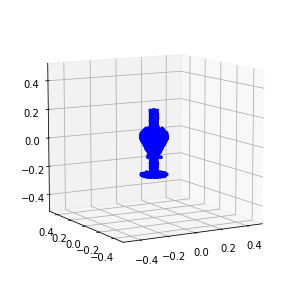

vase


In [276]:
k = np.random.randint(len(chimeras))
Point_Cloud(chimeras[k][0]).plot()
print int_to_cl[chimeras[k][1]]

In [277]:
top_data_dir = '/orions4-zfs/projects/optas/DATA/'

In [278]:
experiment_name = 'sup_clf_with_chimeras'

experiment_name = '_'.join([experiment_name, 'mnet', model_net,  'pts', str(n_pc_points)])

train_dir = osp.join(top_data_dir, 'OUT/exploration/nn_models/sup_clf')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir);

In [279]:
n_input = [n_pc, 3]
n_classes = int(model_net)

encoder = encoder_with_convs_and_symmetry_new
decoder = decoder_with_fc_only

decoder_args = {'layer_sizes': [256, 256, n_classes], 'b_norm': False}


encoder_args = {'n_filters': [64, 128, 256, 256],
                'filter_sizes': [1, 1, 1, 1],
                'strides': [1, 1, 1, 1],
                'b_norm': True
               }

conf = Conf(
            n_input = n_input,
            n_output = [n_classes],
            training_epochs = 200,
            batch_size = 128,
            train_dir = train_dir,
            loss_display_step = 1,
            saver_step = 20,
            learning_rate = 0.0005,
            z_rotate = False, 
            encoder = encoder,
            decoder = decoder,
            encoder_args = encoder_args,
            decoder_args = decoder_args
            )


conf.one_hot = False
conf.experiment_name = experiment_name
conf.save(osp.join(conf.train_dir, 'configuration'))    
    
reset_tf_graph()
pnet_clf = PointNetClassifier(experiment_name, conf)

In [ ]:
c = conf
for _ in xrange(c.training_epochs):
    loss, duration = pnet_clf._single_epoch_train(train_data, c)
    epoch = int(pnet_clf.sess.run(pnet_clf.epoch.assign_add(tf.constant(1.0))))
    print 'TRAIN epoch: %d loss: %f' % (epoch, loss)
    if epoch % 2 == 0:
        avg_ac = classify_pclouds(pnet_clf, test_data.point_clouds, 100, test_data.labels)[1]
        print 'TEST epoch: %d accuracy: %f' % (epoch, avg_ac)

TRAIN epoch: 1 loss: 1.502348
TRAIN epoch: 2 loss: 0.750569
TEST epoch: 2 accuracy: 0.749595
TRAIN epoch: 3 loss: 0.604260
TRAIN epoch: 4 loss: 0.533801
TEST epoch: 4 accuracy: 0.788898
TRAIN epoch: 5 loss: 0.481114
TRAIN epoch: 6 loss: 0.439132
TEST epoch: 6 accuracy: 0.805511
TRAIN epoch: 7 loss: 0.414627
TRAIN epoch: 8 loss: 0.387374
TEST epoch: 8 accuracy: 0.815235
TRAIN epoch: 9 loss: 0.359221
TRAIN epoch: 10 loss: 0.348521
TEST epoch: 10 accuracy: 0.806726
TRAIN epoch: 11 loss: 0.328342
TRAIN epoch: 12 loss: 0.319091
TEST epoch: 12 accuracy: 0.834279
TRAIN epoch: 13 loss: 0.304305
TRAIN epoch: 14 loss: 0.299274
TEST epoch: 14 accuracy: 0.828606
TRAIN epoch: 15 loss: 0.285953
TRAIN epoch: 16 loss: 0.283234
TEST epoch: 16 accuracy: 0.829822
TRAIN epoch: 17 loss: 0.267957
TRAIN epoch: 18 loss: 0.247507
TEST epoch: 18 accuracy: 0.816451
TRAIN epoch: 19 loss: 0.253662
TRAIN epoch: 20 loss: 0.244702
TEST epoch: 20 accuracy: 0.836710
TRAIN epoch: 21 loss: 0.238983
TRAIN epoch: 22 loss: 